In [42]:
import torch
import random
import torchaudio
from torchaudio import transforms


In [26]:
class AudioUtil():
    
  # ----------------------------
  # Load an audio file. Return the signal as a tensor and the sample rate
  # ----------------------------
  @staticmethod
  def open(audio_file):
    sig, sr = torchaudio.load(audio_file)
    return (sig, sr)

  # ----------------------------
  # Convert the given audio to the desired number of channels
  # ----------------------------
  @staticmethod
  def rechannel(aud, new_channel):
    sig, sr = aud

    if (sig.shape[0] == new_channel):
      # Nothing to do
      return aud

    if (new_channel == 1):
      # Convert from stereo to mono by selecting only the first channel
      resig = sig[:1, :]
    else:
      # Convert from mono to stereo by duplicating the first channel
      resig = torch.cat([sig, sig])

    return ((resig, sr))
    
  # ----------------------------
  # Since Resample applies to a single channel, we resample one channel at a time
  # ----------------------------
  @staticmethod
  def resample(aud, newsr):
    sig, sr = aud

    if (sr == newsr):
      # Nothing to do
      return aud

    num_channels = sig.shape[0]
    # Resample first channel
    resig = torchaudio.transforms.Resample(sr, newsr)(sig[:1,:])
    if (num_channels > 1):
      # Resample the second channel and merge both channels
      retwo = torchaudio.transforms.Resample(sr, newsr)(sig[1:,:])
      resig = torch.cat([resig, retwo])

    return ((resig, newsr))
    
  # ----------------------------
  # Pad (or truncate) the signal to a fixed length 'max_ms' in milliseconds
  # ----------------------------
  @staticmethod
  def pad_trunc(aud, max_ms):
    sig, sr = aud
    num_rows, sig_len = sig.shape
    max_len = sr//1000 * max_ms

    if (sig_len > max_len):
      # Truncate the signal to the given length
      sig = sig[:,:max_len]

    elif (sig_len < max_len):
      # Length of padding to add at the beginning and end of the signal
      pad_begin_len = random.randint(0, max_len - sig_len)
      pad_end_len = max_len - sig_len - pad_begin_len

      # Pad with 0s
      pad_begin = torch.zeros((num_rows, pad_begin_len))
      pad_end = torch.zeros((num_rows, pad_end_len))

      sig = torch.cat((pad_begin, sig, pad_end), 1)
      
    return (sig, sr)
    
  # ----------------------------
  # Shifts the signal to the left or right by some percent. Values at the end
  # are 'wrapped around' to the start of the transformed signal.
  # ----------------------------
  @staticmethod
  def time_shift(aud, shift_limit):
    sig,sr = aud
    _, sig_len = sig.shape
    shift_amt = int(random.random() * shift_limit * sig_len)
    return (sig.roll(shift_amt), sr)
    
  # ----------------------------
  # Generate a Spectrogram
  # ----------------------------
  @staticmethod
  def spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None):
    sig,sr = aud
    top_db = 80

    # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
    spec = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)

    # Convert to decibels
    spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
    return (spec)
    
  # ----------------------------
  # Augment the Spectrogram by masking out some sections of it in both the frequency
  # dimension (ie. horizontal bars) and the time dimension (vertical bars) to prevent
  # overfitting and to help the model generalise better. The masked sections are
  # replaced with the mean value.
  # ----------------------------
  @staticmethod
  def spectro_augment(spec, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
    _, n_mels, n_steps = spec.shape
    mask_value = spec.mean()
    aug_spec = spec

    freq_mask_param = max_mask_pct * n_mels
    for _ in range(n_freq_masks):
      aug_spec = transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_value)

    time_mask_param = max_mask_pct * n_steps
    for _ in range(n_time_masks):
      aug_spec = transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)

    return aug_spec
    
    
    

In [21]:
from torch.utils.data import DataLoader, Dataset, random_split
import torchaudio

# ----------------------------
# Sound Dataset
# ----------------------------
class SoundDS(Dataset):
  def __init__(self, df):
    self.df = df
    #self.data_path = str(data_path)
    self.duration = 4000
    self.sr = 48000
    self.channel = 1
    self.shift_pct = 0.4
            
  # ----------------------------
  # Number of items in dataset
  # ----------------------------
  def __len__(self):
    return len(self.df)    
    
  # ----------------------------
  # Get i'th item in dataset
  # ----------------------------
  def __getitem__(self, idx):
    # Absolute file path of the audio file - concatenate the audio directory with
    # the relative path
    audio_file = self.df.loc[idx, 'path']
    # Get the Class ID
    class_id = self.df.loc[idx, 'classID']

    aud = AudioUtil.open(audio_file)
    # Some sounds have a higher sample rate, or fewer channels compared to the
    # majority. So make all sounds have the same number of channels and same 
    # sample rate. Unless the sample rate is the same, the pad_trunc will still
    # result in arrays of different lengths, even though the sound duration is
    # the same.
    reaud = AudioUtil.resample(aud, self.sr)
    rechan = AudioUtil.rechannel(reaud, self.channel)

    dur_aud = AudioUtil.pad_trunc(rechan, self.duration)
    shift_aud = AudioUtil.time_shift(dur_aud, self.shift_pct)
    sgram = AudioUtil.spectro_gram(shift_aud, n_mels=64, n_fft=1024, hop_len=None)
    aug_sgram = AudioUtil.spectro_augment(sgram, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)

    return aug_sgram, class_id

In [27]:

import numpy as np
import pandas as pd
import os

DATA_PATH = 'D:\\dawnload_chrome\\archive\\audio_speech_actors_01-24'
EMOTIONS = {1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 0:'surprise'} # surprise je promenjen sa 8 na 0

data = pd.DataFrame(columns=['classID', 'Emotion intensity', 'Gender','path'])
for dirname, _, filenames in os.walk(DATA_PATH):
    for filename in filenames:
        file_path = os.path.join(dirname, filename)
        identifiers = filename.split('.')[0].split('-')
        emotion = (int(identifiers[2]))
        if emotion == 8: 
            emotion = 0
        if int(identifiers[3]) == 1:
            emotion_intensity = 'normal' 
        else:
            emotion_intensity = 'strong'
        if int(identifiers[6])%2 == 0:
            gender = 'female'
        else:
            gender = 'male'
        
        data = data.append({"classID": emotion,
                            "Emotion intensity": emotion_intensity,
                            "Gender": gender,
                            "path": file_path
                             },
                             ignore_index = True
                          )

In [28]:
data.head()

,classID,Emotion intensity,Gender,path
0,1,normal,male,D:\dawnload_chrome\archive\audio_speech_actors...
1,1,normal,male,D:\dawnload_chrome\archive\audio_speech_actors...
2,1,normal,male,D:\dawnload_chrome\archive\audio_speech_actors...
3,1,normal,male,D:\dawnload_chrome\archive\audio_speech_actors...
4,2,normal,male,D:\dawnload_chrome\archive\audio_speech_actors...


In [30]:
from torch.utils.data import random_split

myds = SoundDS(data)

# Random split of 80:20 between training and validation
num_items = len(myds)
num_train = round(num_items * 0.8)
num_val = num_items - num_train
train_ds, val_ds = random_split(myds, [num_train, num_val])

# Create training and validation data loaders
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=32, shuffle=False)

In [44]:
import torch.nn.functional as F
from torch.nn import init
import torch.nn as nn
# ----------------------------
# Audio Classification Model
# ----------------------------
class AudioClassifier (nn.Module):
    # ----------------------------
    # Build the model architecture
    # ----------------------------
    def __init__(self):
        super().__init__()
        conv_layers = []

        # First Convolution Block with Relu and Batch Norm. Use Kaiming Initialization
        self.conv1 = nn.Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(8)
        #inti weight
        init.kaiming_normal_(self.conv1.weight, a=0.1)
        self.conv1.bias.data.zero_()
        conv_layers += [self.conv1, self.relu1, self.bn1]

        # Second Convolution Block
        self.conv2 = nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(16)
        init.kaiming_normal_(self.conv2.weight, a=0.1)
        self.conv2.bias.data.zero_()
        conv_layers += [self.conv2, self.relu2, self.bn2]

        # Second Convolution Block
        self.conv3 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(32)
        init.kaiming_normal_(self.conv3.weight, a=0.1)
        self.conv3.bias.data.zero_()
        conv_layers += [self.conv3, self.relu3, self.bn3]

        # Second Convolution Block
        self.conv4 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(64)
        init.kaiming_normal_(self.conv4.weight, a=0.1)
        self.conv4.bias.data.zero_()
        conv_layers += [self.conv4, self.relu4, self.bn4]
        
        # Second Convolution Block
        self.conv5 = nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu5 = nn.ReLU()
        self.bn5 = nn.BatchNorm2d(128)
        init.kaiming_normal_(self.conv5.weight, a=0.1)
        self.conv5.bias.data.zero_()
        conv_layers += [self.conv5, self.relu5, self.bn5]

        # Linear Classifier
        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        self.lin = nn.Linear(in_features=128, out_features=8)

        # Wrap the Convolutional Blocks
        self.conv = nn.Sequential(*conv_layers)
 
    # ----------------------------
    # Forward pass computations
    # ----------------------------
    def forward(self, x):
        # Run the convolutional blocks
        x = self.conv(x)

        # Adaptive pool and flatten for input to linear layer
        x = self.ap(x)
        x = x.view(x.shape[0], -1)

        # Linear layer
        x = self.lin(x)

        # Final output
        return x

# Create the model and put it on the GPU if available
myModel = AudioClassifier()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
myModel = myModel.to(device)
# Check that it is on Cuda
next(myModel.parameters()).device

device(type='cpu')

In [45]:
# Loss Function, Optimizer and Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(myModel.parameters(),lr=0.001)


In [53]:
# ----------------------------
# Training Loop
# ----------------------------
def training(model, train_dl, num_epochs):
    
    
    losses_eboch=[]
    acc_eboch=[]
  
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,
                                                steps_per_epoch=int(len(train_dl)),
                                                epochs=num_epochs,
                                                anneal_strategy='linear')
    # Repeat for each epoch
    for epoch in range(num_epochs):
        ###
        running_loss = 0.0
        correct_prediction = 0
        total_prediction = 0

        # Repeat for each batch in the training set
        for i, data in enumerate(train_dl):
            # Get the input features and target labels, and put them on the GPU
            inputs, labels = data[0].to(device), data[1].to(device)

            # Normalize the inputs
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s

            # Zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

            # Keep stats for Loss and Accuracy
            running_loss += loss.item()

            # Get the predicted class with the highest score
            _, prediction = torch.max(outputs,1)
            # Count of predictions that matched the target label
            correct_prediction += (prediction == labels).sum().item()
            total_prediction += prediction.shape[0]
            ###############

            ################
            #if i % 10 == 0:    # print every 10 mini-batches
            #    print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 10))

        # Print stats at the end of the epoch
        num_batches = len(train_dl)
        avg_loss = running_loss / num_batches
        acc = correct_prediction/total_prediction
        print(f'Epoch: {epoch}, Loss: {avg_loss:.2f}, Accuracy: {acc:.2f}')
        losses_eboch.append(avg_loss)
        acc_eboch.append(acc)
    print('Finished Training')
    return losses_eboch,acc_eboch
  

In [56]:
myModel

AudioClassifier(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (relu1): ReLU()
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (relu2): ReLU()
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (relu3): ReLU()
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (relu4): ReLU()
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (relu5): ReLU()
  (bn5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ap): AdaptiveAvgPool2d(output_size=1)
  (lin): Linear(in_featu

In [57]:
loss,acc=training(myModel,train_dl,100)

Epoch: 0, Loss: 1.88, Accuracy: 0.27
Epoch: 1, Loss: 1.86, Accuracy: 0.29
Epoch: 2, Loss: 1.83, Accuracy: 0.29
Epoch: 3, Loss: 1.80, Accuracy: 0.30
Epoch: 4, Loss: 1.78, Accuracy: 0.32
Epoch: 5, Loss: 1.76, Accuracy: 0.32
Epoch: 6, Loss: 1.75, Accuracy: 0.33
Epoch: 7, Loss: 1.72, Accuracy: 0.36
Epoch: 8, Loss: 1.70, Accuracy: 0.36
Epoch: 9, Loss: 1.69, Accuracy: 0.36
Epoch: 10, Loss: 1.66, Accuracy: 0.38
Epoch: 11, Loss: 1.64, Accuracy: 0.37
Epoch: 12, Loss: 1.62, Accuracy: 0.40
Epoch: 13, Loss: 1.62, Accuracy: 0.40
Epoch: 14, Loss: 1.60, Accuracy: 0.41
Epoch: 15, Loss: 1.56, Accuracy: 0.42
Epoch: 16, Loss: 1.53, Accuracy: 0.42
Epoch: 17, Loss: 1.52, Accuracy: 0.44
Epoch: 18, Loss: 1.50, Accuracy: 0.43
Epoch: 19, Loss: 1.47, Accuracy: 0.45
Epoch: 20, Loss: 1.43, Accuracy: 0.47
Epoch: 21, Loss: 1.44, Accuracy: 0.45
Epoch: 22, Loss: 1.42, Accuracy: 0.46
Epoch: 23, Loss: 1.37, Accuracy: 0.49
Epoch: 24, Loss: 1.37, Accuracy: 0.49
Epoch: 25, Loss: 1.37, Accuracy: 0.49
Epoch: 26, Loss: 1.31,

In [59]:
torch.save(myModel,"final_model.pth")

In [61]:
from matplotlib import pyplot as plt

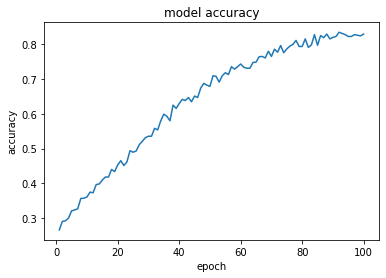

In [68]:
# summarize history for accuracy
plt.plot(range(1,101),acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()


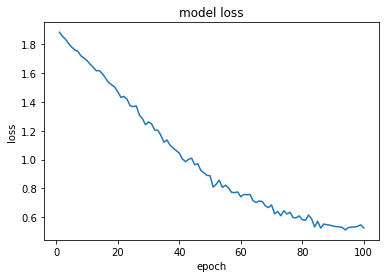

In [69]:
# summarize history for loss
plt.plot(range(1,101),loss)
###################
#plt.ylim(0.4,0.5)
#plt.xlim(1,8)
###################
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [70]:
loss,acc=training(myModel,train_dl,100)

Epoch: 0, Loss: 0.55, Accuracy: 0.82
Epoch: 1, Loss: 0.52, Accuracy: 0.82
Epoch: 2, Loss: 0.50, Accuracy: 0.84
Epoch: 3, Loss: 0.54, Accuracy: 0.83
Epoch: 4, Loss: 0.53, Accuracy: 0.83
Epoch: 5, Loss: 0.54, Accuracy: 0.82
Epoch: 6, Loss: 0.52, Accuracy: 0.84
Epoch: 7, Loss: 0.53, Accuracy: 0.83
Epoch: 8, Loss: 0.54, Accuracy: 0.82
Epoch: 9, Loss: 0.55, Accuracy: 0.81
Epoch: 10, Loss: 0.54, Accuracy: 0.81
Epoch: 11, Loss: 0.53, Accuracy: 0.82
Epoch: 12, Loss: 0.52, Accuracy: 0.84
Epoch: 13, Loss: 0.55, Accuracy: 0.81
Epoch: 14, Loss: 0.52, Accuracy: 0.84
Epoch: 15, Loss: 0.55, Accuracy: 0.82
Epoch: 16, Loss: 0.53, Accuracy: 0.82
Epoch: 17, Loss: 0.52, Accuracy: 0.83
Epoch: 18, Loss: 0.53, Accuracy: 0.82
Epoch: 19, Loss: 0.54, Accuracy: 0.81
Epoch: 20, Loss: 0.54, Accuracy: 0.82
Epoch: 21, Loss: 0.50, Accuracy: 0.83
Epoch: 22, Loss: 0.53, Accuracy: 0.82
Epoch: 23, Loss: 0.55, Accuracy: 0.83
Epoch: 24, Loss: 0.52, Accuracy: 0.82
Epoch: 25, Loss: 0.53, Accuracy: 0.82
Epoch: 26, Loss: 0.52,

In [72]:
torch.save(myModel,"final_model.pth")

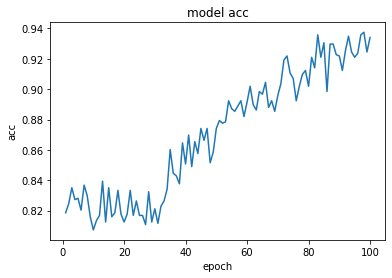

In [74]:
# summarize history for acc
plt.plot(range(1,101),acc)
###################
#plt.ylim(0.4,0.5)
#plt.xlim(1,8)
###################
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.show()

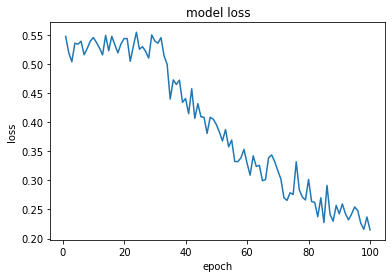

In [75]:
# summarize history for loss
plt.plot(range(1,101),loss)
###################
#plt.ylim(0.4,0.5)
#plt.xlim(1,8)
###################
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [76]:
loss,acc=training(myModel,train_dl,100)

Epoch: 0, Loss: 0.24, Accuracy: 0.92
Epoch: 1, Loss: 0.25, Accuracy: 0.92
Epoch: 2, Loss: 0.24, Accuracy: 0.92
Epoch: 3, Loss: 0.24, Accuracy: 0.93
Epoch: 4, Loss: 0.23, Accuracy: 0.92
Epoch: 5, Loss: 0.22, Accuracy: 0.93
Epoch: 6, Loss: 0.22, Accuracy: 0.94
Epoch: 7, Loss: 0.23, Accuracy: 0.93
Epoch: 8, Loss: 0.22, Accuracy: 0.94
Epoch: 9, Loss: 0.27, Accuracy: 0.91
Epoch: 10, Loss: 0.25, Accuracy: 0.91
Epoch: 11, Loss: 0.29, Accuracy: 0.90
Epoch: 12, Loss: 0.25, Accuracy: 0.92
Epoch: 13, Loss: 0.25, Accuracy: 0.93
Epoch: 14, Loss: 0.27, Accuracy: 0.92
Epoch: 15, Loss: 0.25, Accuracy: 0.93
Epoch: 16, Loss: 0.27, Accuracy: 0.91
Epoch: 17, Loss: 0.27, Accuracy: 0.90
Epoch: 18, Loss: 0.27, Accuracy: 0.91
Epoch: 19, Loss: 0.26, Accuracy: 0.91
Epoch: 20, Loss: 0.27, Accuracy: 0.91
Epoch: 21, Loss: 0.30, Accuracy: 0.89
Epoch: 22, Loss: 0.29, Accuracy: 0.90
Epoch: 23, Loss: 0.30, Accuracy: 0.90
Epoch: 24, Loss: 0.29, Accuracy: 0.90
Epoch: 25, Loss: 0.30, Accuracy: 0.89
Epoch: 26, Loss: 0.30,

In [78]:
torch.save(myModel,"final_model.pth")

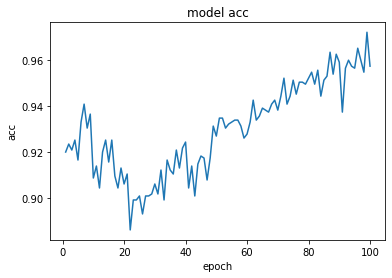

In [80]:
# summarize history for acc
plt.plot(range(1,101),acc)
###################
#plt.ylim(0.3,1)
#plt.xlim(1,8)
###################
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.show()

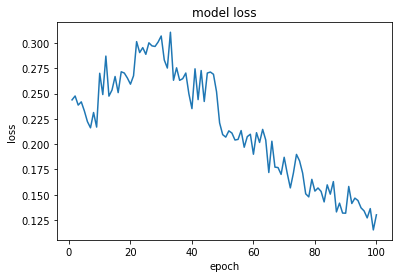

In [81]:
# summarize history for loss
plt.plot(range(1,101),loss)
###################
#plt.ylim(0.4,0.5)
#plt.xlim(1,8)
###################
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [85]:
# ----------------------------
# Inference
# ----------------------------
def inference (model, val_dl):
    
    correct_prediction = 0
    total_prediction = 0

    # Disable gradient updates
    with torch.no_grad():
        for data in val_dl:
            # Get the input features and target labels, and put them on the GPU
            inputs, labels = data[0].to(device), data[1].to(device)

            # Normalize the inputs
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s

            # Get predictions
            outputs = model(inputs)
            # Get the predicted class with the highest score
            _, prediction = torch.max(outputs,1)
            # Count of predictions that matched the target label
            correct_prediction += (prediction == labels).sum().item()
            total_prediction += prediction.shape[0]
    
    acc = correct_prediction/total_prediction
    print(f'Accuracy: {acc:.2f}, Total items: {total_prediction}')



In [86]:
# Run inference on trained model with the validation set
inference(myModel, val_dl)

Accuracy: 0.81, Total items: 288
